In [139]:
import pandas as pd
import sqlite3

## Подключение к базе данных

In [140]:
conn = sqlite3.connect('../data/checking-logs.sqlite', check_same_thread=False)

## Анализируйте только пользователей, а не администраторов

In [141]:
query = """
SELECT
    uid, timestamp
FROM 
    checker
WHERE 
    uid LIKE 'user_%'
"""

commit = pd.io.sql.read_sql(query, conn, parse_dates='timestamp')
commit

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


## Для каждого часа рассчитайте среднее количество коммитов в рабочие дни и выходные

In [ ]:
commit = pd.read_sql(query, conn, parse_dates=['timestamp'])
commit['hour'] = commit['timestamp'].dt.hour
commit['weekday'] = commit['timestamp'].dt.dayofweek
commit['type'] = commit['weekday'].apply(lambda x: 'Work' if x < 5 else 'Weekend')
commit['day'] = commit['timestamp'].dt.date  
commit = commit.drop(columns=['weekday'])
commit

,uid,timestamp,hour,type,day
0,user_4,2020-04-17 05:19:02.744528,5,Work,2020-04-17
1,user_4,2020-04-17 05:22:35.249331,5,Work,2020-04-17
2,user_4,2020-04-17 05:22:45.549397,5,Work,2020-04-17
3,user_4,2020-04-17 05:34:14.691200,5,Work,2020-04-17
4,user_4,2020-04-17 05:34:24.422370,5,Work,2020-04-17
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,20,Work,2020-05-21
3203,user_1,2020-05-21 20:22:41.785725,20,Work,2020-05-21
3204,user_1,2020-05-21 20:22:41.877806,20,Work,2020-05-21
3205,user_1,2020-05-21 20:37:00.129678,20,Work,2020-05-21


In [143]:
commits_grouped = (
    commit.groupby(['type', 'day', 'hour'])
    .size()
    .groupby(['type', 'hour'])
    .mean()
    .reset_index(name='uid')  
)
commits_grouped

,type,hour,uid
0,Weekend,0,2.000000
1,Weekend,1,6.000000
2,Weekend,3,1.000000
3,Weekend,5,2.000000
4,Weekend,7,4.000000
5,Weekend,8,7.000000
6,Weekend,9,3.666667
7,Weekend,10,7.000000
8,Weekend,11,23.600000
9,Weekend,12,9.500000


In [144]:
commits_grouped = commits_grouped.reset_index()
pivot_table = pd.pivot(commits_grouped, values='uid', index='hour',columns='type')
pivot_table

type,Weekend,Work
hour,,
0,2.000000,3.000000
1,6.000000,NaN
3,1.000000,2.000000
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000
10,7.000000,13.200000


In [145]:
print(pivot_table.loc[17])

type
Weekend     7.142857
Work       16.000000
Name: 17, dtype: float64


## Создать график

array([<Axes: title={'center': 'Weekend'}, xlabel='hour'>,
       <Axes: title={'center': 'Work'}, xlabel='hour'>], dtype=object)

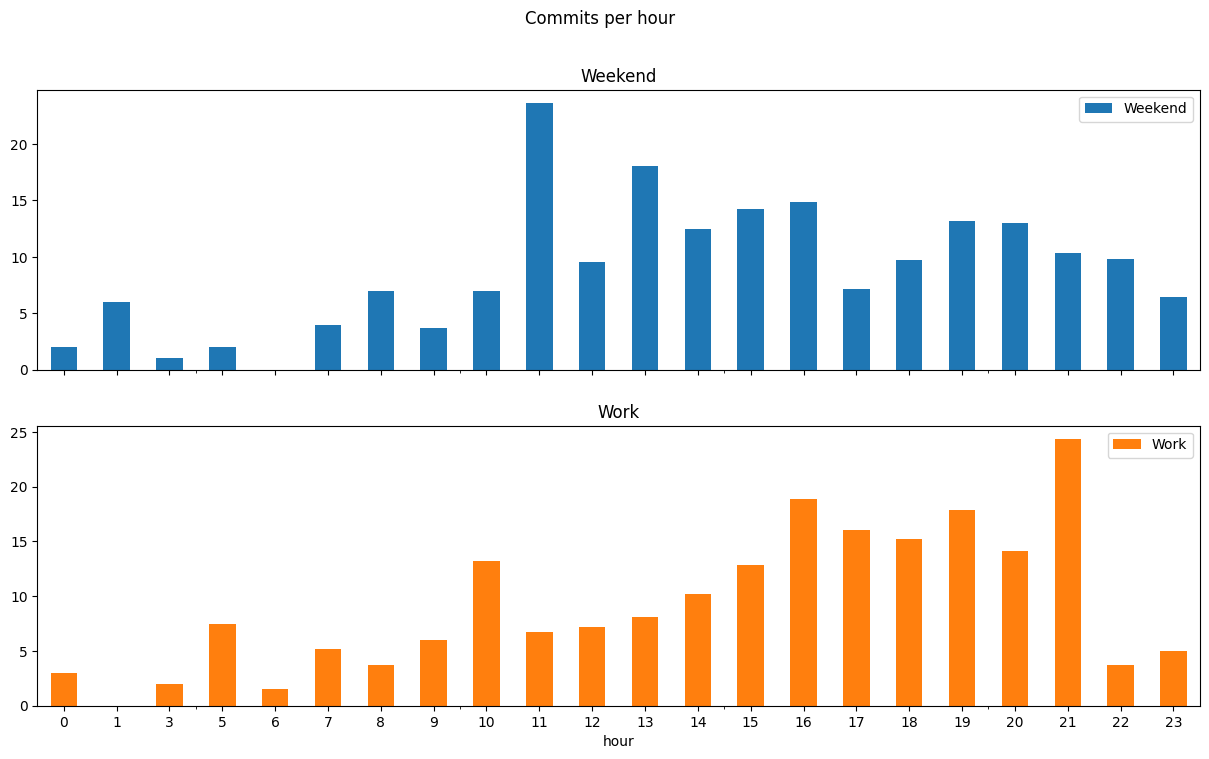

In [146]:
pivot_table.plot(kind = 'bar', title = 'Commits per hour', figsize=(15,8), rot = 0, subplots = True)

## «Отличается ли динамика в рабочие и выходные дни?»

In [147]:
work_max = pivot_table[pivot_table['Work'] == pivot_table['Work'].max()]
print(work_max.index[0])

21


In [148]:
week_max = pivot_table[pivot_table['Weekend'] == pivot_table['Weekend'].max()]
print(week_max.index[0])

11


In [149]:
print("Ответ:")
print(f"- В рабочие дни чаще всего коммитят в {work_max.index[0]}:00")
print(f"- В выходные дни чаще всего коммитят в {week_max.index[0]}:00")

Ответ:
- В рабочие дни чаще всего коммитят в 21:00
- В выходные дни чаще всего коммитят в 11:00


## ВЫВОД: динамика отличается, в выходной день пользователи активнее утром, а в рабочий вечером

## Закрыть соединение с базой данных

In [150]:
conn.close()